In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import pickle
from scipy import stats

import holidays
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.trend import STLForecaster

from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.forecasting.compose import BaggingForecaster
from sktime.forecasting.fbprophet import Prophet

## SARIMA

In [6]:
df_sarima = pd.read_csv('data.csv', delimiter=';', parse_dates=['REPORTDATE'], dayfirst=True,index_col=0)
df_sarima.index = pd.to_datetime(df_sarima.index)
df_sarima['VALUE'] = df_sarima['VALUE'].ewm(span=7, adjust=False).mean()
df_sarima.dropna(inplace=True)

<AxesSubplot:>

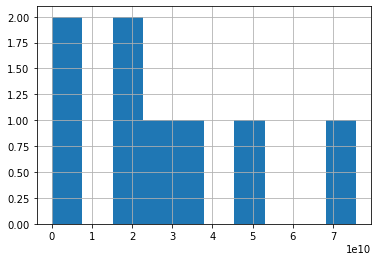

In [7]:
df_sarima.VALUE.describe().hist()

In [8]:
SPLIT_DATE = '2018-09-10'

### SARIMA daily

<AxesSubplot:xlabel='REPORTDATE'>

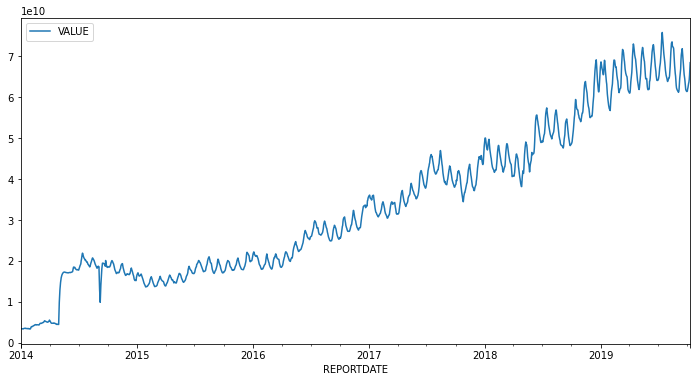

In [9]:
df_sarima.plot(figsize=(12,6))

In [10]:
test = sm.tsa.adfuller(df_sarima)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -0.290694923260342
p-value:  0.9268119096280844
Critical values:  {'1%': -3.4334917336814543, '5%': -2.862927879505365, '10%': -2.567508842556946}
есть единичные корни, ряд не стационарен


In [11]:
df_sarima_diff = df_sarima.diff(periods=1).dropna()

In [12]:
test = sm.tsa.adfuller(df_sarima_diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -10.927392299755288
p-value:  1.0021402856780086e-19
Critical values:  {'1%': -3.4334932438197754, '5%': -2.862928546266631, '10%': -2.5675091975687785}
единичных корней нет, ряд стационарен


<AxesSubplot:xlabel='REPORTDATE'>

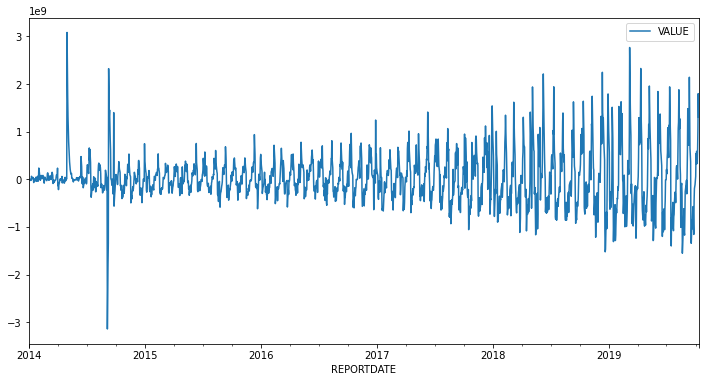

In [13]:
df_sarima_diff.plot(figsize=(12,6))

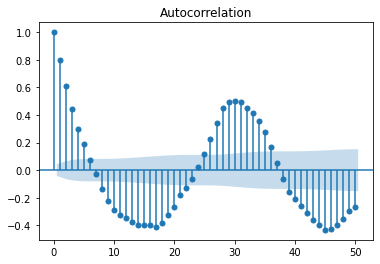

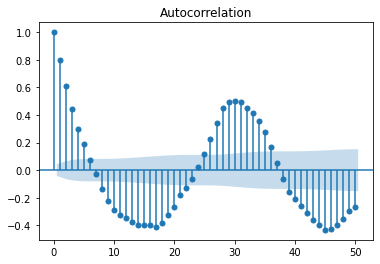

In [14]:
sm.graphics.tsa.plot_acf(df_sarima_diff.values.squeeze(), lags=50)

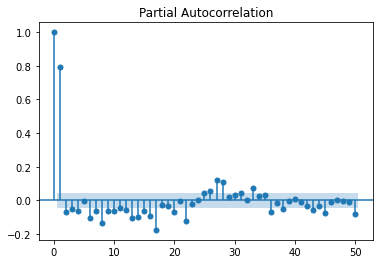

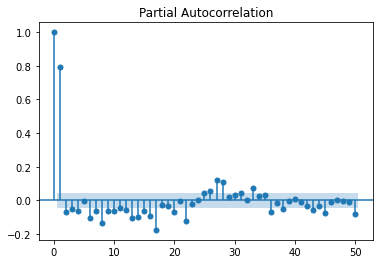

In [15]:
sm.graphics.tsa.plot_pacf(df_sarima_diff, lags=50)

<AxesSubplot:xlabel='REPORTDATE'>

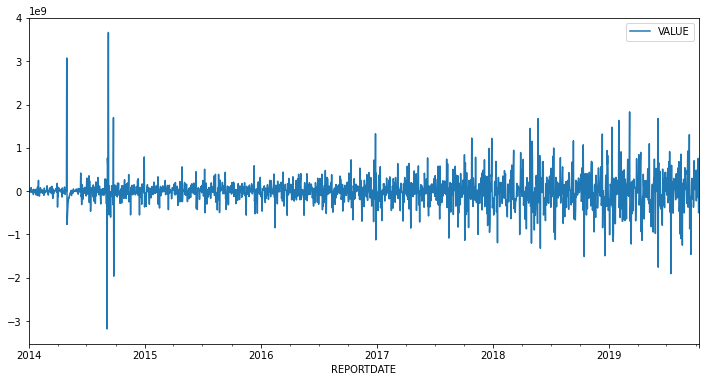

In [16]:
df_sarima_diff_diff = df_sarima_diff.diff(1).dropna()
df_sarima_diff_diff.plot(figsize=(12,6))

In [17]:
test = sm.tsa.adfuller(df_sarima_diff_diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -24.759281407336715
p-value:  0.0
Critical values:  {'1%': -3.4334947554105537, '5%': -2.862929213668854, '10%': -2.567509552921939}
единичных корней нет, ряд стационарен


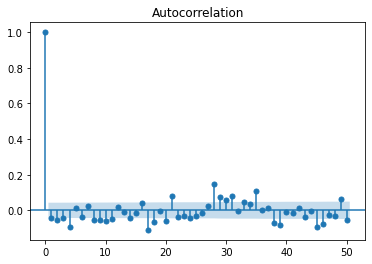

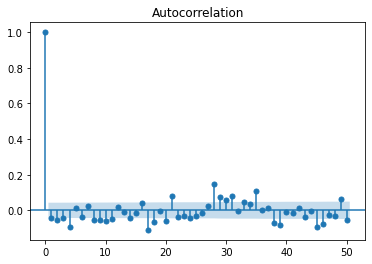

In [18]:
sm.graphics.tsa.plot_acf(df_sarima_diff_diff.values.squeeze(), lags=50)

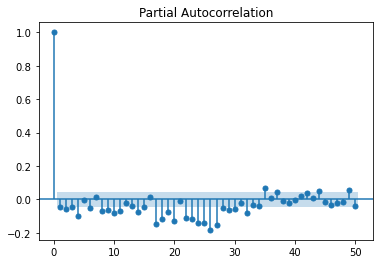

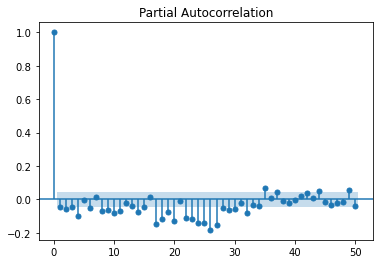

In [19]:
sm.graphics.tsa.plot_pacf(df_sarima_diff_diff, lags=50)

<AxesSubplot:xlabel='REPORTDATE'>

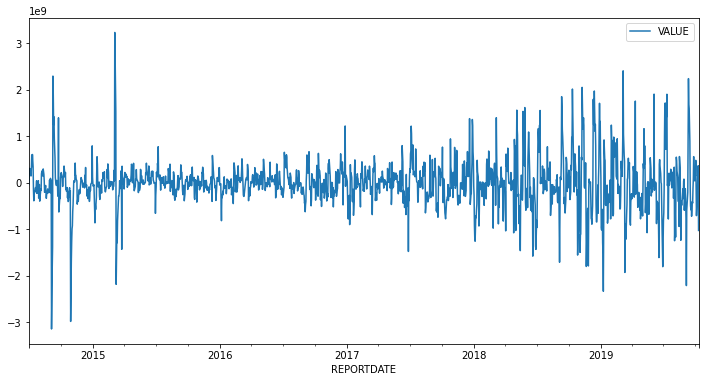

In [20]:
df_sarima_diff_season = df_sarima_diff.diff(182).dropna()
df_sarima_diff_season.plot(figsize=(12,6))

In [21]:
test = sm.tsa.adfuller(df_sarima_diff_season)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -11.767288769455446
p-value:  1.111214895311012e-21
Critical values:  {'1%': -3.433787340386774, '5%': -2.8630583903440656, '10%': -2.567578333092222}
единичных корней нет, ряд стационарен


<AxesSubplot:xlabel='REPORTDATE'>

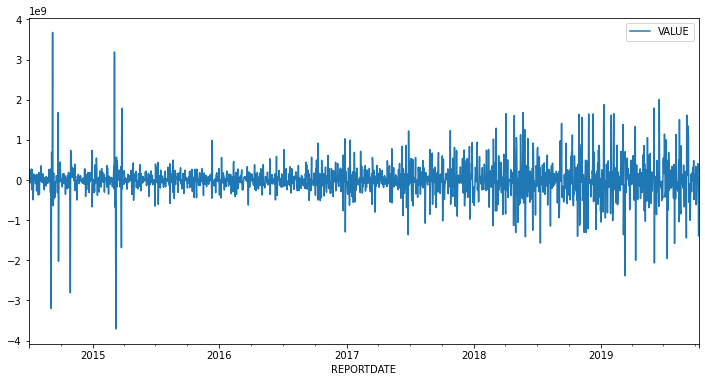

In [22]:
df_sarima_diff_season_1lvl = df_sarima_diff_season.diff().dropna()
df_sarima_diff_season_1lvl.plot(figsize=(12,6))

In [23]:
test = sm.tsa.adfuller(df_sarima_diff_season_1lvl)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -15.37741826965287
p-value:  3.443489125700691e-28
Critical values:  {'1%': -3.4337963982844437, '5%': -2.8630623892170872, '10%': -2.5675804623268697}
единичных корней нет, ряд стационарен


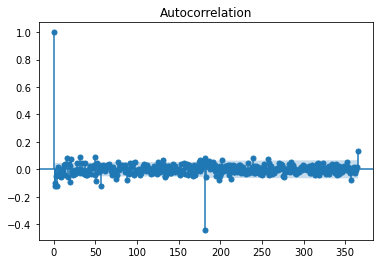

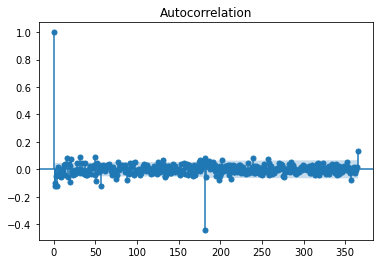

In [24]:
sm.graphics.tsa.plot_acf(df_sarima_diff_season_1lvl.values.squeeze(), lags=365)

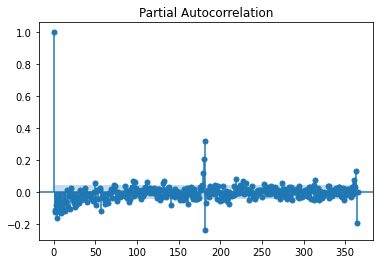

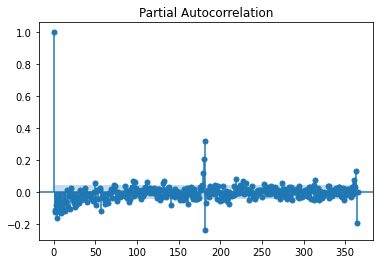

In [25]:
sm.graphics.tsa.plot_pacf(df_sarima_diff_season_1lvl, lags=365)

In [42]:
ARIMA_PARAMS = (1, 1, 1)
SARIMA_PARAMS = (1, 1, 1, 182)
model = sm.tsa.statespace.SARIMAX(train, order=ARIMA_PARAMS, seasonal_order=SARIMA_PARAMS)
print(f'ARIMA: {ARIMA_PARAMS} \nSARIMA: {SARIMA_PARAMS}')

ARIMA: (1, 1, 1) 
SARIMA: (1, 1, 1, 182)


/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [43]:
%%time
model_fitted = model.fit()

CPU times: user 2h 9s, sys: 12min 27s, total: 2h 12min 37s
Wall time: 21min 33s


In [44]:
future_forecast = model_fitted.forecast(steps=500)
post_forecast = model_fitted.predict()

<AxesSubplot:>

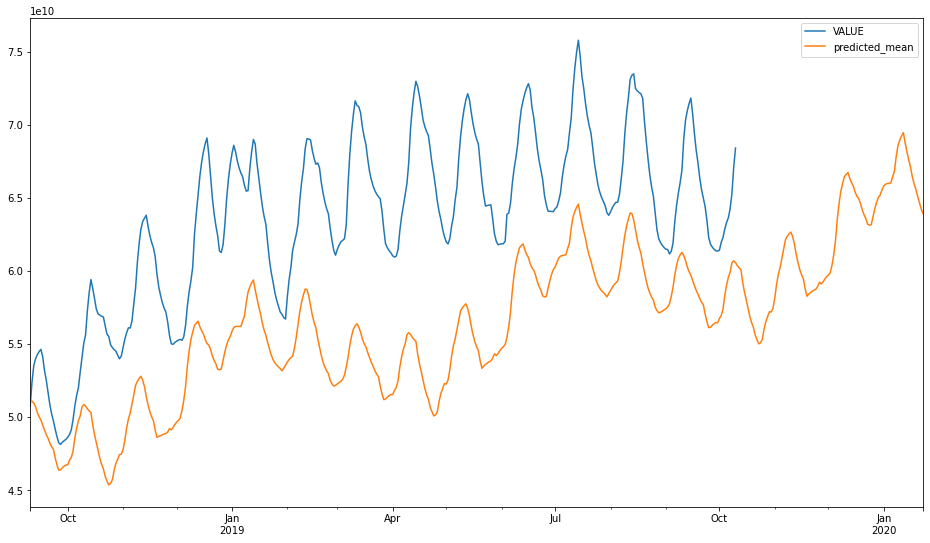

In [46]:
pd.concat([test, future_forecast], axis=1).plot(figsize=(16,9))

<AxesSubplot:>

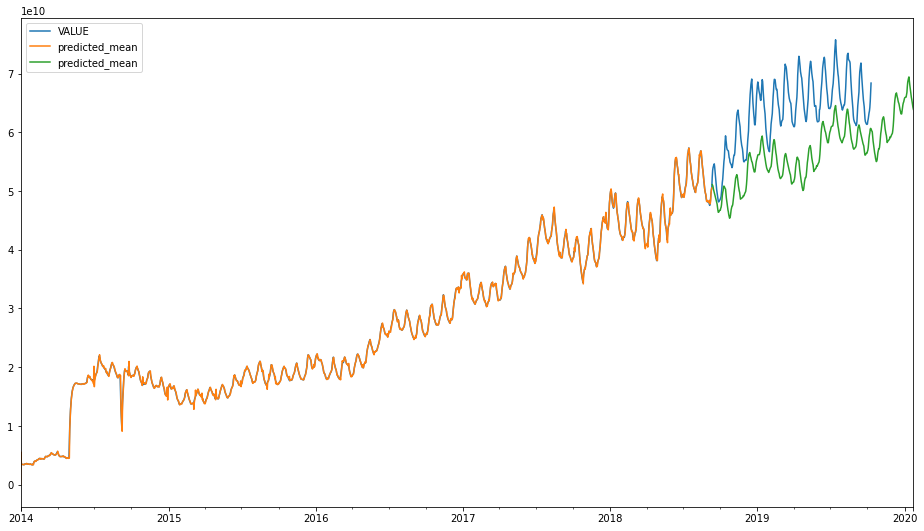

In [47]:
pd.concat([df_sarima, post_forecast, future_forecast],axis=1).plot(figsize=(16,9))

In [48]:
print('TRAIN')
print(f'MAE: {mean_absolute_error(train, post_forecast)}')
print(f'MSE: {mean_squared_error(train, post_forecast)}')
print(f'MAPE: {mean_absolute_percentage_error(train, post_forecast)}')
print(f'R^2: {r2_score(train, post_forecast)}')
print('TEST')
print(f'MAE: {mean_absolute_error(test, future_forecast[:test.shape[0]])}')
print(f'MSE: {mean_squared_error(test, future_forecast[:test.shape[0]])}')
print(f'MAPE: {mean_absolute_percentage_error(test, future_forecast[:test.shape[0]])}')
print(f'R^2: {r2_score(test, future_forecast[:test.shape[0]])}')

TRAIN
MAE: 149855465.1313867
MSE: 8.839890682440862e+16
MAPE: 0.00722961602106838
R^2: 0.9994749710139808
TEST
MAE: 8529647992.398175
MSE: 8.722765585798903e+19
MAPE: 0.13143642276319298
R^2: -1.5169197179238414


### SARIMA weeks

<AxesSubplot:xlabel='REPORTDATE'>

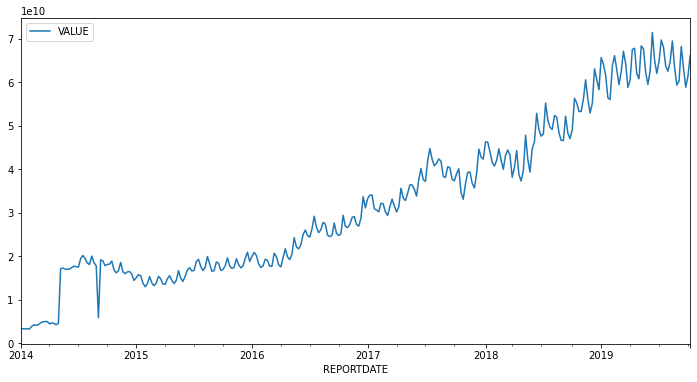

In [174]:
df_sarima_w = df_sarima.resample('W').min()
df_sarima_w.plot(figsize=(12,6))

In [175]:
test = sm.tsa.adfuller(df_sarima_w)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -0.24321148370118717
p-value:  0.9331710747313462
Critical values:  {'1%': -3.4535050041524245, '5%': -2.8717352599720294, '10%': -2.5722024776854417}
есть единичные корни, ряд не стационарен


In [176]:
df_sarima_w_diff = df_sarima_w.diff(periods=1).dropna()

In [177]:
test = sm.tsa.adfuller(df_sarima_w_diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -6.391508328443728
p-value:  2.1003401044742e-08
Critical values:  {'1%': -3.4535872903895797, '5%': -2.871771355211212, '10%': -2.5722217283277127}
единичных корней нет, ряд стационарен


<AxesSubplot:xlabel='REPORTDATE'>

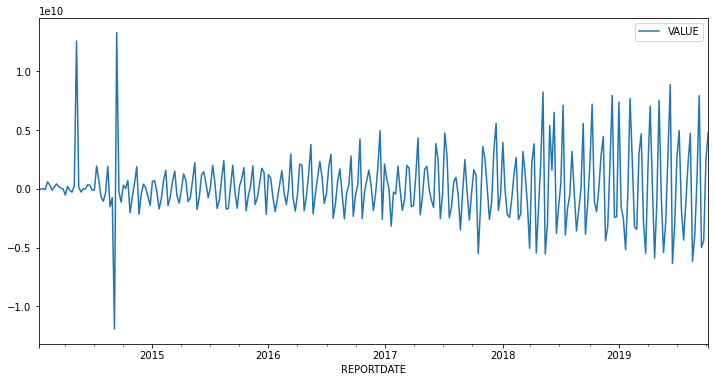

In [178]:
df_sarima_w_diff.plot(figsize=(12,6))

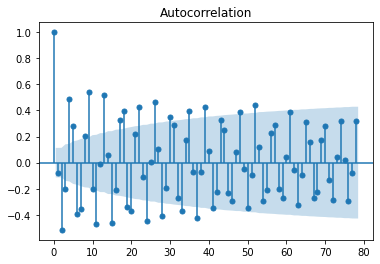

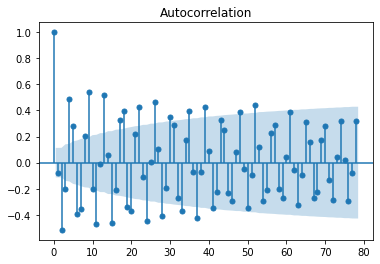

In [179]:
sm.graphics.tsa.plot_acf(df_sarima_w_diff.values.squeeze(), lags=78)

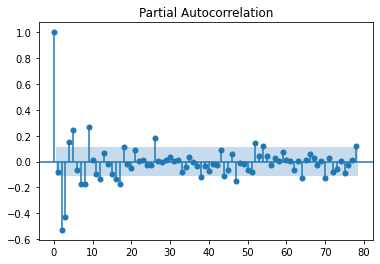

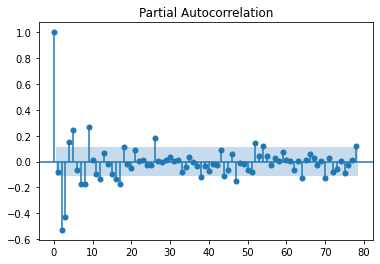

In [180]:
sm.graphics.tsa.plot_pacf(df_sarima_w_diff, lags=78)

Попробуем посмотреть на ряд с полугодовой разностью и опередлить сезонность

<AxesSubplot:xlabel='REPORTDATE'>

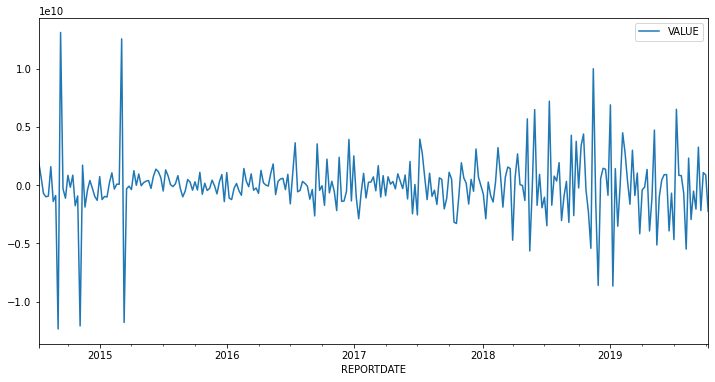

In [181]:
df_sarima_w_diff_season = df_sarima_w_diff.diff(26).dropna()
df_sarima_w_diff_season.plot(figsize=(12,6))

In [182]:
test = sm.tsa.adfuller(df_sarima_w_diff_season)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -6.326187281655318
p-value:  2.982435986701028e-08
Critical values:  {'1%': -3.455175292841607, '5%': -2.8724677563219485, '10%': -2.57259315846006}
единичных корней нет, ряд стационарен


<AxesSubplot:xlabel='REPORTDATE'>

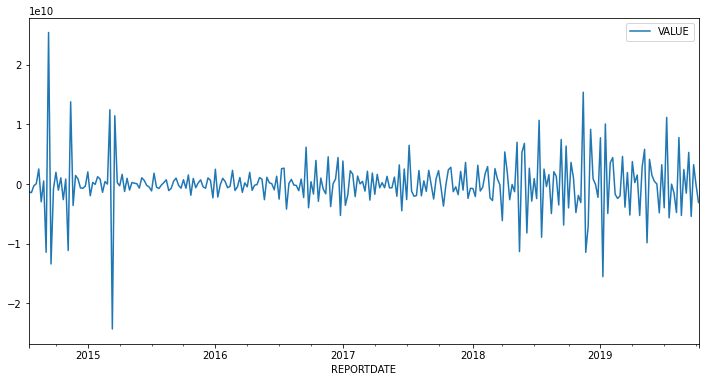

In [183]:
df_sarima_w_diff_season_1lvl = df_sarima_w_diff_season.diff().dropna()
df_sarima_w_diff_season_1lvl.plot(figsize=(12,6))

In [184]:
test = sm.tsa.adfuller(df_sarima_w_diff_season_1lvl)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -6.764578060216909
p-value:  2.7377063227683942e-09
Critical values:  {'1%': -3.4560535712549925, '5%': -2.8728527662442334, '10%': -2.5727985212493754}
единичных корней нет, ряд стационарен


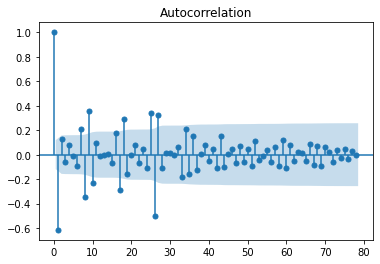

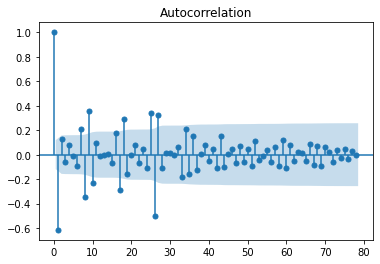

In [185]:
sm.graphics.tsa.plot_acf(df_sarima_w_diff_season_1lvl.values.squeeze(), lags=78)

/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


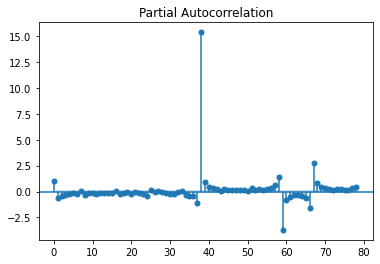

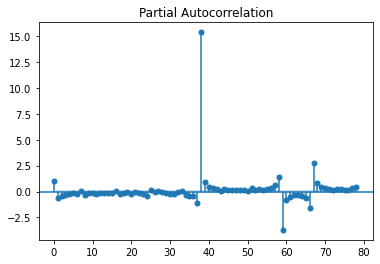

In [186]:
sm.graphics.tsa.plot_pacf(df_sarima_w_diff_season_1lvl, lags=78)

По данным можно определить что параметры для модели SARIMA следующие:
<br>
__p__ = 34<br>
__d__ = 1<br>
__q__ = 26<br>
__P__ = 0<br>
__D__ = 1<br>
__Q__ = 0<br>
__s__ = 26

In [187]:
test = df_sarima_w.loc[SPLIT_DATE:]

train = df_sarima_w.loc[:SPLIT_DATE]

In [188]:
model_w = sm.tsa.statespace.SARIMAX(train, order=(34, 1, 26), seasonal_order=(0, 1, 0, 26))

In [189]:
model_fitted_w = model_w.fit()

/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [190]:
future_forecast = model_fitted_w.forecast(steps=100)

In [191]:
post_forecast = model_fitted_w.predict()

<AxesSubplot:>

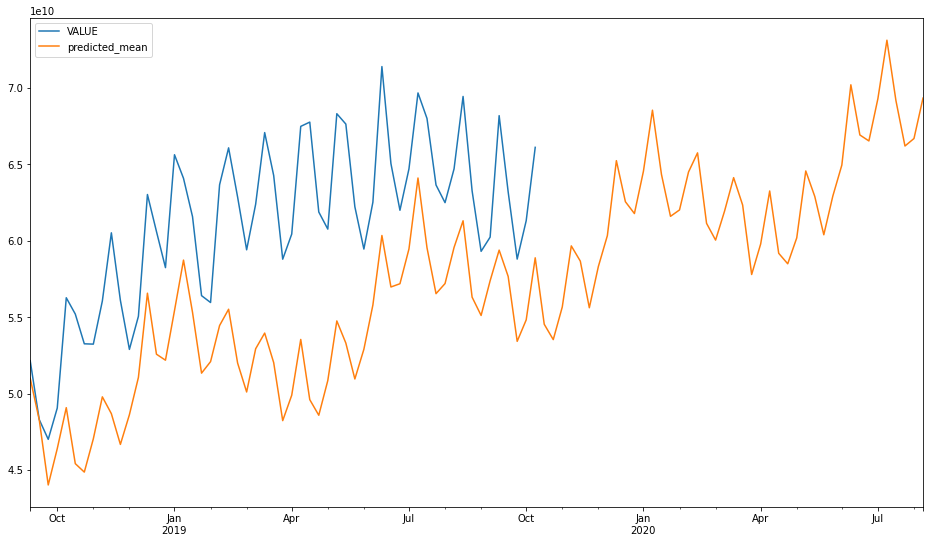

In [192]:
pd.concat([test, future_forecast], axis=1).plot(figsize=(16,9))

<AxesSubplot:>

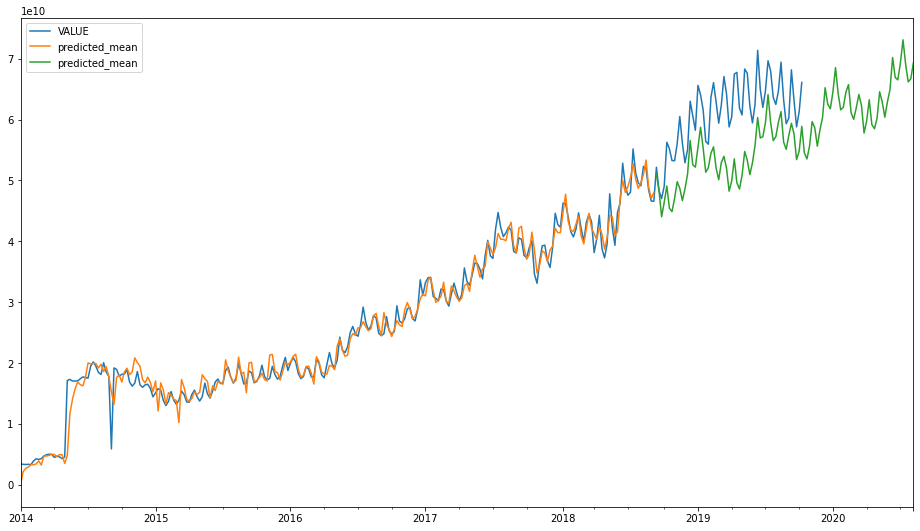

In [193]:
pd.concat([df_sarima_w, post_forecast, future_forecast],axis=1).plot(figsize=(16,9))

In [194]:
print('TRAIN')
print(f'MAE: {mean_absolute_error(train, post_forecast)}')
print(f'MSE: {mean_squared_error(train, post_forecast)}')
print(f'MAPE: {mean_absolute_percentage_error(train, post_forecast)}')
print(f'R^2: {r2_score(train, post_forecast)}')
print('TEST')
print(f'MAE: {mean_absolute_error(test, future_forecast[:len(test)])}')
print(f'MSE: {mean_squared_error(test, future_forecast[:len(test)])}')
print(f'MAPE: {mean_absolute_percentage_error(test, future_forecast[:len(test)])}')
print(f'R^2: {r2_score(test, future_forecast[:len(test)])}')

TRAIN
MAE: 1173048578.4543178
MSE: 3.180021367562748e+18
MAPE: 0.06511611130543654
R^2: 0.9795487248416777
TEST
MAE: 7811667083.546882
MSE: 7.3416269651158516e+19
MAPE: 0.12556941355305828
R^2: -1.4175888613310725


### SARIMA monthly

<AxesSubplot:xlabel='REPORTDATE'>

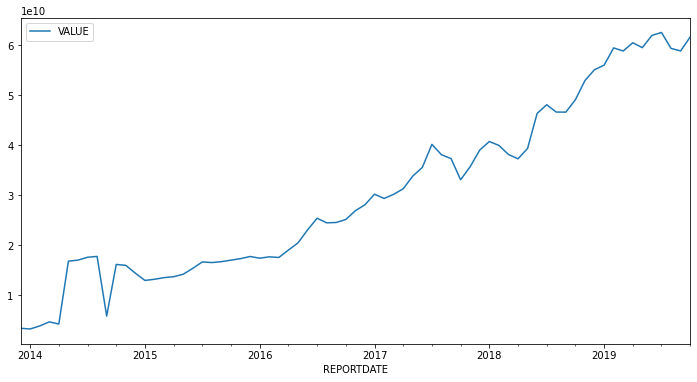

In [60]:
df_sarima_m = df_sarima.resample('M').min()
df_sarima_m.plot(figsize=(12,6))

In [61]:
df_sarima_m_diff = df_sarima_m.diff(periods=1).dropna()

In [62]:
test = sm.tsa.adfuller(df_sarima_m_diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -6.197261366374882
p-value:  5.9237858383574124e-08
Critical values:  {'1%': -3.5319549603840894, '5%': -2.905755128523123, '10%': -2.5903569458676765}
единичных корней нет, ряд стационарен


In [63]:
m = df_sarima_m_diff.shape[0]//2+1
r1 = sm.stats.DescrStatsW(df_sarima_m_diff.iloc[m:])
r2 = sm.stats.DescrStatsW(df_sarima_m_diff.iloc[:m])
print('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  [0.67367327]


<AxesSubplot:xlabel='REPORTDATE'>

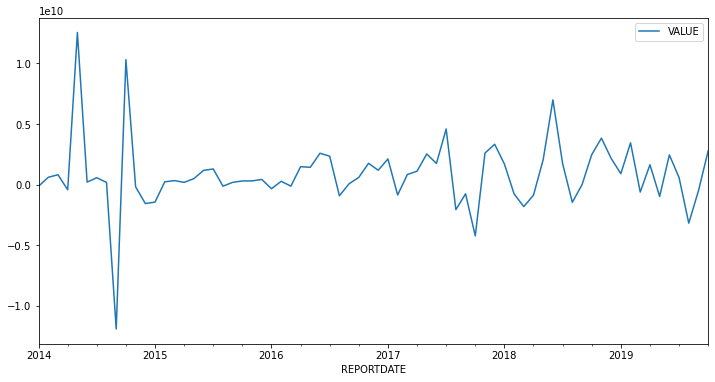

In [64]:
df_sarima_m_diff.plot(figsize=(12,6))

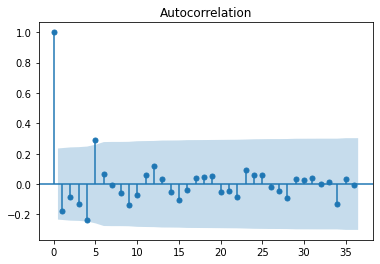

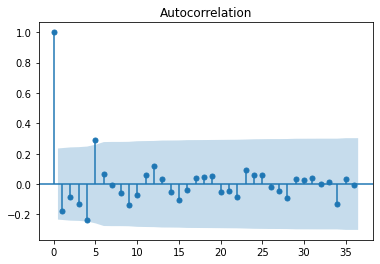

In [65]:
sm.graphics.tsa.plot_acf(df_sarima_m_diff.values.squeeze(), lags=36)

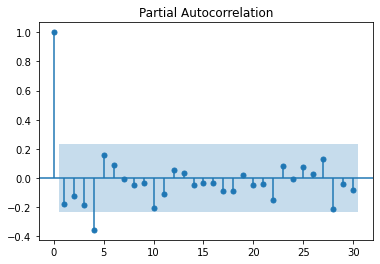

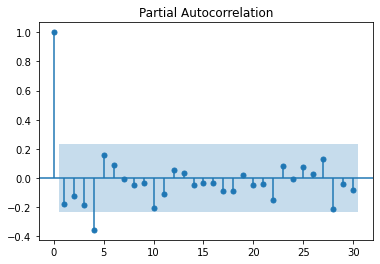

In [66]:
sm.graphics.tsa.plot_pacf(df_sarima_m_diff, lags=30)

<AxesSubplot:xlabel='REPORTDATE'>

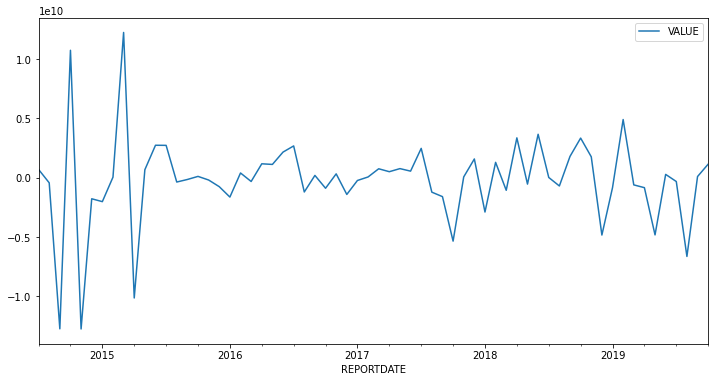

In [67]:
df_sarima_m_diff_season = df_sarima_m_diff.diff(6).dropna()
df_sarima_m_diff_season.plot(figsize=(12,6))

In [68]:
test = sm.tsa.adfuller(df_sarima_m_diff_season)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -11.70848201585672
p-value:  1.5087736006689115e-21
Critical values:  {'1%': -3.5386953618719676, '5%': -2.9086446751210775, '10%': -2.591896782564878}
единичных корней нет, ряд стационарен


<AxesSubplot:xlabel='REPORTDATE'>

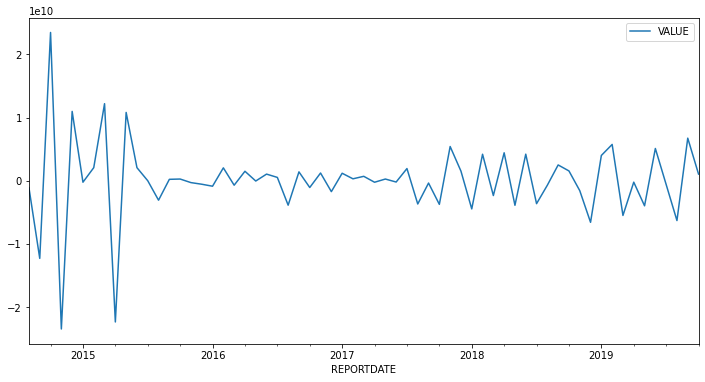

In [69]:
df_sarima_m_diff_season_1lvl = df_sarima_m_diff_season.diff().dropna()
df_sarima_m_diff_season_1lvl.plot(figsize=(12,6))

In [70]:
test = sm.tsa.adfuller(df_sarima_m_diff_season_1lvl)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -10.43833284346015
p-value:  1.545308582351319e-18
Critical values:  {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
единичных корней нет, ряд стационарен


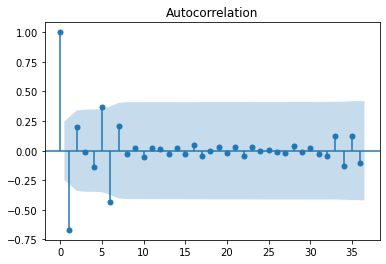

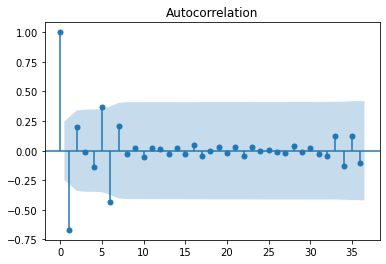

In [71]:
sm.graphics.tsa.plot_acf(df_sarima_m_diff_season_1lvl.values.squeeze(), lags=36)

/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


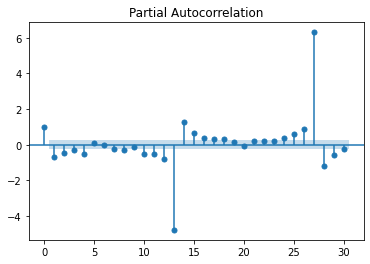

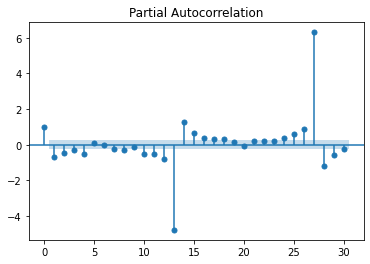

In [72]:
sm.graphics.tsa.plot_pacf(df_sarima_m_diff_season_1lvl, lags=30)

In [73]:
test = df_sarima_m.iloc[-12:]

train = df_sarima_m.iloc[:-12]

По данным можно определить что параметры для модели SARIMA следующие:
<br>
__p__ = 13<br>
__d__ = 1<br>
__q__ = 6<br>
__P__ = 0<br>
__D__ = 1<br>
__Q__ = 0<br>
__s__ = 6

In [102]:
model_m = sm.tsa.statespace.SARIMAX(train, order=(4, 1, 5), seasonal_order=(2, 1, 1, 6))

In [103]:
model_fitted_m = model_m.fit()

/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/brutalfacepalm/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [104]:
future_forecast = model_fitted_m.forecast(steps=12)

In [105]:
post_forecast = model_fitted_m.predict()

<AxesSubplot:>

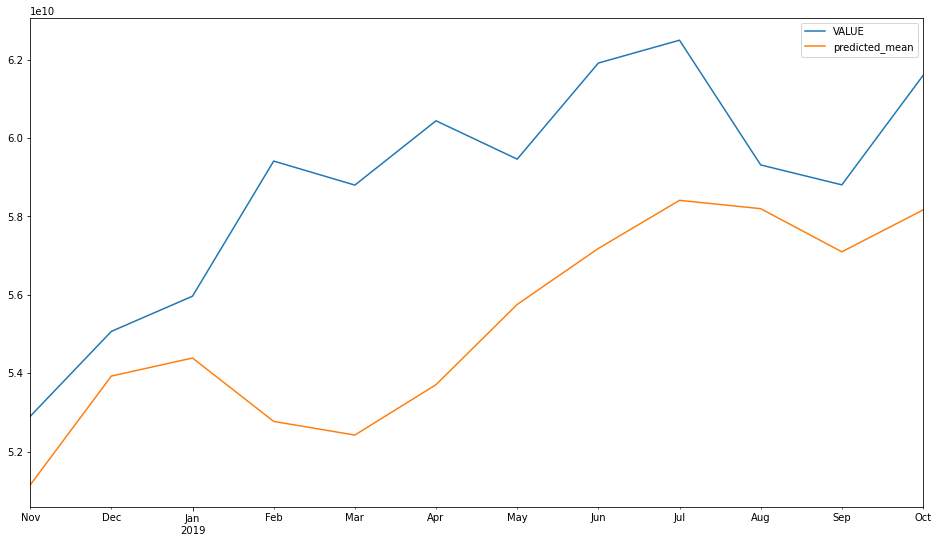

In [106]:
pd.concat([test, future_forecast], axis=1).plot(figsize=(16,9))

<AxesSubplot:>

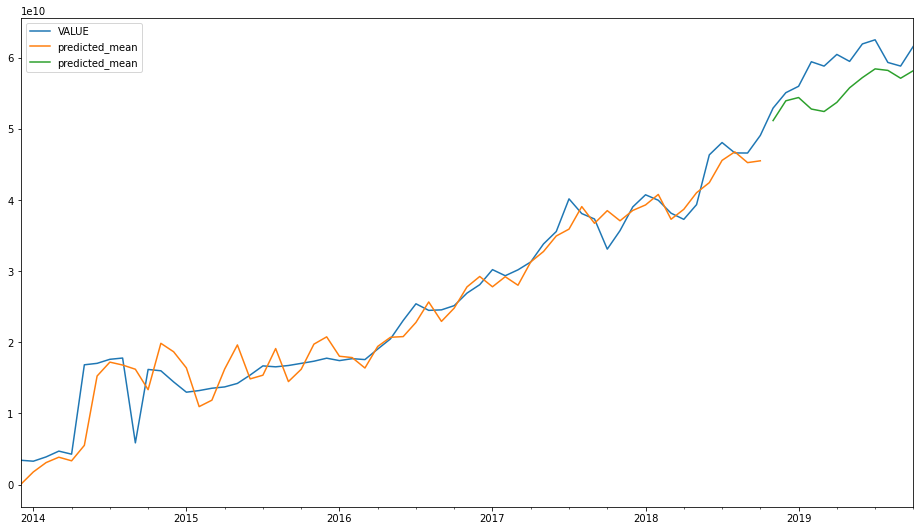

In [107]:
pd.concat([df_sarima_m, post_forecast, future_forecast],axis=1).plot(figsize=(16,9))

In [108]:
print('TRAIN')
print(f'MAE: {mean_absolute_error(train, post_forecast)}')
print(f'MSE: {mean_squared_error(train, post_forecast)}')
print(f'MAPE: {mean_absolute_percentage_error(train, post_forecast)}')
print(f'R^2: {r2_score(train, post_forecast)}')
print('TEST')
print(f'MAE: {mean_absolute_error(test, future_forecast[:50])}')
print(f'MSE: {mean_squared_error(test, future_forecast[:50])}')
print(f'MAPE: {mean_absolute_percentage_error(test, future_forecast[:50])}')
print(f'R^2: {r2_score(test, future_forecast[:50])}')

TRAIN
MAE: 2054787643.4392483
MSE: 8.612643892817064e+18
MAPE: 0.14897613946383678
R^2: 0.9446603523538598
TEST
MAE: 3584566530.8924427
MSE: 1.7156160531086785e+19
MAPE: 0.06013197396403369
R^2: -1.243834006458271


## SKtime

In [26]:
test = df_sarima.loc[SPLIT_DATE:]

train = df_sarima.loc[:SPLIT_DATE]

In [27]:
train.index.freq='D'
test.index.freq='D'

In [29]:
sarimax = SARIMAX(order=(1, 1, 1), trend=[-1,-1,0,0], seasonal_order=(1, 1, 1, 182))
sarimax.fit(train)

SARIMAX(order=(1, 1, 1), seasonal_order=(1, 1, 1, 182), trend=[-1, -1, 0, 0])

mape: 0.13196916722317065


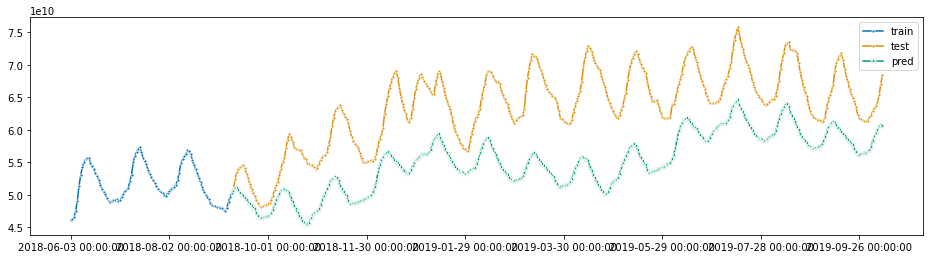

In [30]:
pred = sarimax.predict(fh=ForecastingHorizon(test.index, is_relative=False))
plot_series(train.iloc[-100:,:], test, pred, labels=["train", "test", "pred"], markers=['.', '.', '*'])
print(f'mape: {mean_absolute_percentage_error(test, pred)}')

In [93]:
stl = STLForecaster(sp=182, seasonal=31, trend=365, 
                    robust=True, inner_iter=20, outer_iter=20)
stl.fit(train)

STLForecaster(inner_iter=20, outer_iter=20, robust=True, seasonal=31, sp=182,
              trend=365)

mape: 0.09372853333317262


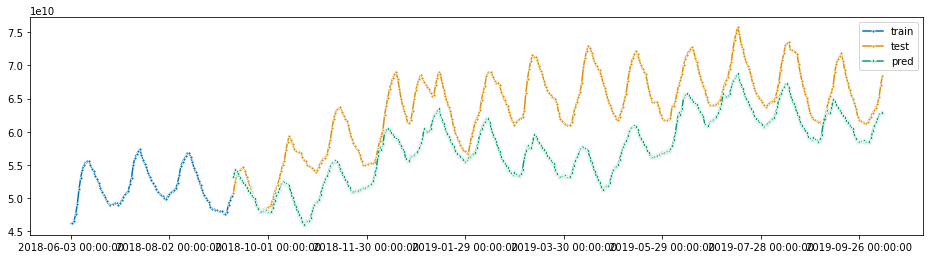

In [94]:
pred = stl.predict(fh=ForecastingHorizon(test.index, is_relative=False))
plot_series(train.iloc[-100:,:], test, pred, labels=["train", "test", "pred"], markers=['.', '.', '*'])
print(f'mape: {mean_absolute_percentage_error(test, pred)}')

In [110]:
bagging = BaggingForecaster(
    STLBootstrapTransformer(sp=182), 
    STLForecaster(sp=182, seasonal=31, trend=365, 
                    robust=True, inner_iter=20, outer_iter=20),
    Prophet( 
        add_seasonality = 182,
        seasonality_mode='multiplicate',
        n_changepoints=int(len(train) / 7),
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_prior_scale=15,
        changepoint_prior_scale=0.07
    ),
)
bagging.fit(train)

BaggingForecaster(bootstrap_transformer=STLBootstrapTransformer(sp=182),
                  forecaster=STLForecaster(inner_iter=20, outer_iter=20,
                                           robust=True, seasonal=31, sp=182,
                                           trend=365),
                  sp=Prophet(add_seasonality=182, changepoint_prior_scale=0.07,
                             n_changepoints=245,
                             seasonality_mode='multiplicate',
                             seasonality_prior_scale=15,
                             weekly_seasonality=True, yearly_seasonality=True))

mape: 0.10867923930928619
mape: 0.09967979284925661


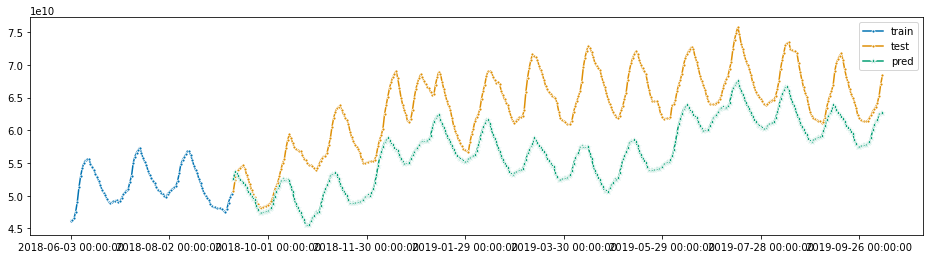

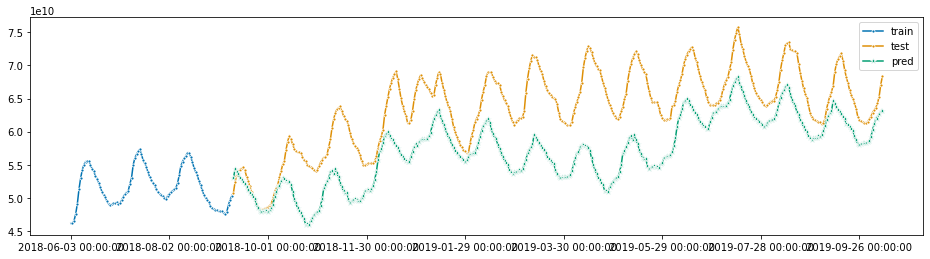

In [111]:
pred = bagging.predict(fh=ForecastingHorizon(test.index, is_relative=False))
plot_series(train.iloc[-100:,:], test, pred, labels=["train", "test", "pred"], markers=['.', '.', '*'])
print(f'mape: {mean_absolute_percentage_error(test, pred)}')

pred = bagging.predict_quantiles(fh=ForecastingHorizon(test.index, is_relative=False), alpha=0.7)
plot_series(train.iloc[-100:,:], test, pred, labels=["train", "test", "pred"], markers=['.', '.', '*'])
print(f'mape: {mean_absolute_percentage_error(test, pred)}')